In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, desc
Base = automap_base()

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
path = "/Users/jessicaborbon/sqlalchemy-challenge/hawaii.sqlite"

In [7]:
# reflect an existing database into a new model
Base.prepare(engine, reflect=True)
# Create a session
session = Session(engine)

Station = Base.classes.station

/var/folders/q0/f73hnm6s6h19dwjnmq7q3thh0000gn/T/ipykernel_81629/2167864697.py:2: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [8]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to each table
Measurement = Base.classes.measurement

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Find the most recent date in the data set.
recent_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
recent_date

('2017-08-23',)

NameError: name 'mdates' is not defined

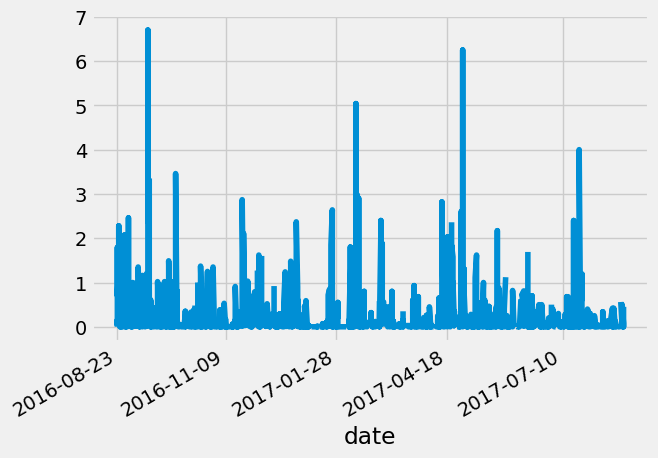

In [12]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
last_date_str = session.query(func.max(Measurement.date)).scalar()
last_date = dt.datetime.strptime(last_date_str, '%Y-%m-%d').date()

# Calculate the date one year ago from the most recent date
one_year_ago = last_date - dt.timedelta(days=365)

# Query to retrieve the last 12 months of precipitation data
query = (session.query(Measurement.date, Measurement.prcp)
         .filter(Measurement.date >= str(one_year_ago))
         .order_by(Measurement.date))

data = query.all()

# Save the query results as a Pandas DataFrame and set the index to the date column
columns = ['date', 'precipitation']
df = pd.DataFrame(data, columns=columns)

# Convert date column to datetime and set as index
df['date'] = pd.to_datetime(df['date'], errors='coerce')
df.set_index('date', inplace=True)

# Sort the DataFrame by date
df.sort_values(by='date', inplace=True)

# Use Pandas Plotting with Matplotlib to plot the data
ax = df.plot(y='precipitation', legend=False)

# Set the custom x-axis tick positions
custom_dates = [pd.Timestamp('2016-08-23'), pd.Timestamp('2016-11-09'), pd.Timestamp('2017-01-28'), pd.Timestamp('2017-04-18'), pd.Timestamp('2017-07-10')]
ax.set_xticks(custom_dates)

# Use DateFormatter to format the custom tick labels
date_format = "%Y-%m-%d"
ax.xaxis.set_major_formatter(mdates.DateFormatter(date_format))

# Rotate the x tick labels for better readability
plt.xticks(rotation=90)

plt.xlabel("Date")
plt.ylabel("Inches")


plt.legend(loc='upper right')
plt.savefig("/Users/jessicaborbon/sqlalchemy-challenge/output/Fig_1.png")
plt.show()


ylabel_text = ax.get_yaxis().get_label().get_text()
print(f"Text(0, 0.5, '{ylabel_text}')")

In [13]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [14]:
# Design a query to calculate the total number of stations in the dataset
session.query(Measurement.station).distinct().count()

9

In [15]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
query = (session.query(Measurement.station, func.count(Measurement.id).label('count'))
         .group_by(Measurement.station)
         .order_by(desc('count')))
# Execute the query and fetch all results
active_stations = query.all()
# Print the results
for station, count in active_stations:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [17]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
most_active_station = query.first()[0]
# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_query = (session.query(
    func.min(Measurement.tobs).label('min_temp'),
    func.max(Measurement.tobs).label('max_temp'),
    func.avg(Measurement.tobs).label('avg_temp'))
    .filter(Measurement.station == most_active_station))

# Execute the query and fetch the results
temperature_stats = temperature_query.one()

# Print the results using the format method
print("{}, {}, {}".format(temperature_stats.min_temp, temperature_stats.max_temp, temperature_stats.avg_temp))

54.0, 85.0, 71.66378066378067


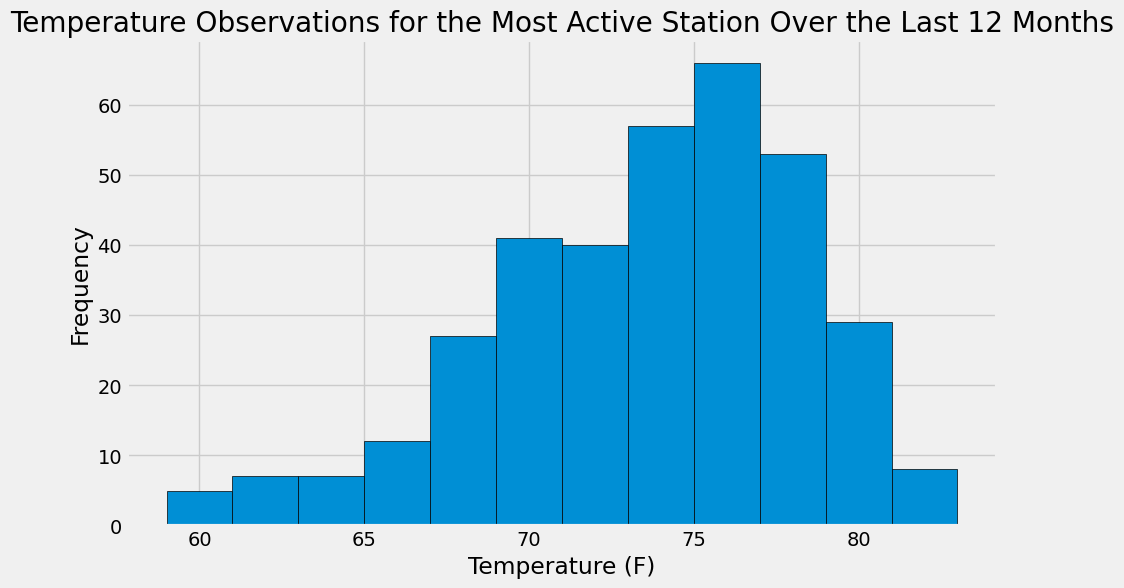

In [18]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

most_active_station_query = (session.query(Measurement.station, func.count(Measurement.id).label('count'))
                             .group_by(Measurement.station)
                             .order_by(desc('count')))

# Execute the query and fetch the most active station
most_active_station = most_active_station_query.first()[0]

# Calculate the date one year ago from the last date in the dataset
last_date_str = session.query(Measurement.date).order_by(desc(Measurement.date)).first()[0]
last_date = dt.datetime.strptime(last_date_str, '%Y-%m-%d').date()
one_year_ago = last_date - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for the most active station
temperature_query = (session.query(Measurement.date, Measurement.tobs)
                     .filter(Measurement.station == most_active_station)
                     .filter(Measurement.date >= one_year_ago)
                     .order_by(Measurement.date))

temperature_data = temperature_query.all()

# Save the query results as a Pandas DataFrame
df = pd.DataFrame(temperature_data, columns=['date', 'temperature'])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
plt.hist(df['temperature'], bins=12, edgecolor='black')
plt.xlabel('Temperature (F)')
plt.ylabel('Frequency')
plt.title('Temperature Observations for the Most Active Station Over the Last 12 Months')
plt.grid(True)

# Save the plot
plt.savefig("/Users/jessicaborbon/sqlalchemy-challenge/output/Fig_2.png")

# Show the plot

plt.show()

# Close Session

In [ ]:
# Close Session
session.close()